In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import psutil
from pympler import asizeof
import sklearn

# Load your CSV file
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
df = pd.read_csv(csv_file_path)

# Initialize constants
IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"

# Initialize the multi-label binarizer
mlb = MultiLabelBinarizer()

unique_labels = df["Finding Labels"].str.split("|").explode().unique()
mlb.fit([unique_labels])
labels_for_class = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

In [3]:
def preprocess_image(file_path, image_size):
    """
    Loads and preprocesses an image from the given file path.
    Resizes to the specified image size and normalizes pixel values.
    """
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    # image = image / 255.0  # Normalize pixel values to [0, 1]
    return image


def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    """
    Prepares images and labels from the dataset for model training.
    - Loads images based on 'Image Index' in the dataframe.
    - Converts 'Finding Labels' to one-hot encoded vectors.
    - Returns arrays of images and labels.
    """
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Construct image path
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)
            # Convert labels into a list of diseases, then one-hot encode
            label = row["Finding Labels"].split("|")
            labels.append(label)
    
    # Convert lists to arrays
    images = np.array(images).reshape(-1, image_size, image_size, 1)  # Adding channel dimension for grayscale
    labels = mlb.transform(labels)  # Convert labels to multi-label one-hot encoding
    
    return images, labels

def weighted_cross_entropy_loss(y_true, y_pred):
    
    tf.print("y_true", y_true, summarize=-1)
    tf.print("y_pred", y_pred, summarize=-1)

    positive_cases = tf.equal(y_true[:, -1], 0)  # Positive when last column is 0
    negative_cases = tf.equal(y_true[:, -1], 1)  # Negative when last column is 1
    
    tf.print("positve_cases", positive_cases, summarize=-1)
    tf.print("negative_cases", negative_cases, summarize=-1)
    
    count_positive = tf.reduce_sum(tf.cast(positive_cases, tf.float32))
    count_negative = tf.reduce_sum(tf.cast(negative_cases, tf.float32))
    
    tf.print("count_positive", count_positive, summarize=-1)
    tf.print("count_negative", count_negative, summarize=-1)
    
    total_samples = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    tf.print("total_samples", total_samples)
    
    # Calculate weights for positive and negative cases
    beta_p = (total_samples) / count_positive
    beta_n = (total_samples) / count_negative
    
    # Clip to prevent division by zero if there are no positive/negative samples (edge case)
    beta_p = tf.clip_by_value(beta_p, 1e-7, 1e7) # Small values to avoid NaNs
    beta_n = tf.clip_by_value(beta_n, 1e-7, 1e7)
    
    tf.print("beta_p", beta_p, summarize=-1)
    tf.print("beta_n", beta_n, summarize=-1)
    
    y_true_binary = tf.stack([positive_cases, negative_cases], axis=-1)
    y_pred_binary = tf.stack([tf.reduce_sum(y_pred[:, :-1], axis=-1), y_pred[:, -1]], axis=-1)
    
    y_true_binary = tf.cast(y_true_binary, tf.float32)
    y_pred_binary = tf.cast(y_pred_binary, tf.float32)
    positive_cases = tf.cast(positive_cases, tf.float32)
    negative_cases = tf.cast(negative_cases, tf.float32)
    
    tf.print("y_true_binary", y_true_binary, summarize=-1)
    tf.print("y_pred_binary", y_pred_binary, summarize=-1)
    
    # Apply weights for positive and negative cases
    weighted_positive_loss = beta_p * tf.reduce_sum(-positive_cases * tf.math.log(y_pred_binary[:, 0] + 1e-7))
    weighted_negative_loss = beta_n * tf.reduce_sum(-negative_cases * tf.math.log(y_pred_binary[:, 1] + 1e-7))
    
    tf.print("weighted_positive_loss", weighted_positive_loss, summarize=-1)
    tf.print("weighted_negative_loss", weighted_negative_loss, summarize=-1)

    # Total weighted cross-entropy loss
    total_loss = weighted_positive_loss + weighted_negative_loss
    
    return total_loss


def create_model_1(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_2(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        # BatchNormalization(), # new
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'), # new
        Conv2D(128, (3, 3), activation='relu'), # new
        # BatchNormalization(),
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(256, activation='relu'), # former 128
        Dropout(0.5),
        Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_3(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu', padding='same'), # new
        Conv2D(256, (3, 3), activation='relu', padding='same'), # new
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(512, activation='relu'), # former 256
        Dropout(0.5),
        Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_4(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(64, (3, 3), activation='relu'), # former 32
        Conv2D(128, (3, 3), activation='relu'), # former 64
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(256, (3, 3), activation='relu'), # former 128
        Conv2D(256, (3, 3), activation='relu'), # former 128
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(512, (3, 3), activation='relu', padding='same'), # former 256
        Conv2D(512, (3, 3), activation='relu', padding='same'), # former 256 
        MaxPooling2D((2, 2)), 
        Dropout(0.3), 
        GlobalAveragePooling2D(), # former Flatten
        Dense(1024, activation='relu'), # former 512
        Dropout(0.4),
        Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation="relu")) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(4, activation='softmax', name="predictions"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC()])
    return model

def evaluate(model, images_val, labels_val, num_classes):
    
    images_val = tf.cast(images_val, np.float32) / 255.0
    
    probabilities = model.predict(images_val)

    auc_per_class = {}

    for class_idx in range(num_classes):
        true_labels = labels_val[:, class_idx]  # True labels for this class
        pred_probs = probabilities[:, class_idx]  # Predicted probabilities for this class

        # Calculate the AUC for this class
        auc = sklearn.metrics.roc_auc_score(true_labels, pred_probs)
        auc_per_class[labels_for_class[class_idx]] = auc        
        
    probabilities_transformed = probabilities.argmax(axis=1)
    labels_val_transformed = labels_val.argmax(axis=1)

    balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_val_transformed, probabilities_transformed)
    acc = sklearn.metrics.accuracy_score(labels_val_transformed, probabilities_transformed)

    return auc_per_class, balanced_acc, acc


In [5]:
IMAGE_SIZE = 224
NUMBER_OF_IMAGES = 1000

def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    # img -= np.array([123.68, 116.78, 103.94], dtype=np.float32)
    return img, label

images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)


################# only used if model requires 3 channels
# images = np.repeat(images[..., np.newaxis], 3, axis=-1).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
# images_test = np.repeat(images_test[..., np.newaxis], 3, axis=-1).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)

100%|██████████| 200/200 [00:01<00:00, 114.53it/s]


In [10]:
BATCH_SIZE = 16

dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
dataset = dataset.map(normalize_image)
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
val_dataset = val_dataset.map(normalize_image)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
    
model = create_model_1(IMAGE_SIZE)
    
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=len(images_train) // BATCH_SIZE, validation_data=val_dataset, validation_steps=len(images_val)//BATCH_SIZE, callbacks=[early_stopping], verbose=1, class_weight=class_weights)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - auc_2: 0.6322 - loss: 1.3841 - val_auc_2: 0.7605 - val_loss: 1.3399
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - auc_2: 0.5942 - loss: 1.3092 - val_auc_2: 0.5974 - val_loss: 1.3595
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - auc_2: 0.5638 - loss: 1.3381 - val_auc_2: 0.4702 - val_loss: 1.3978
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - auc_2: 0.5107 - loss: 1.3721 - val_auc_2: 0.7034 - val_loss: 1.3325
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - auc_2: 0.6005 - loss: 1.2962 - val_auc_2: 0.6268 - val_loss: 1.3477
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - auc_2: 0.5943 - loss: 1.3061 - val_auc_2: 0.5671 - val_loss: 1.3637
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - auc_2: 0.5375 - loss: 1.3307 - val_auc_2: 0.6096 - val_loss: 1.3397
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - auc_2: 0.6533 - loss: 1.2667 - val_auc_2: 0.6773 - val_loss: 1.3202
Epoch 9/20
50/50 ━━━━━━

In [18]:
evals = evaluate(model, images_test, labels_test, len(unique_labels))
print(evals)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
({'Atelectasis': 0.5737092391304348, 'Effusion': 0.7588325652841783, 'Infiltration': 0.6724664224664225, 'No Finding': 0.576343201754386}, 0.34457236842105265, 0.575)


In [14]:
evals = evaluate(model, images_test, labels_test, len(unique_labels))
print(evals)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
({'Atelectasis': 0.5737092391304348, 'Effusion': 0.7588325652841783, 'Infiltration': 0.6724664224664225, 'No Finding': 0.576343201754386}, 0.34457236842105265, 0.575)


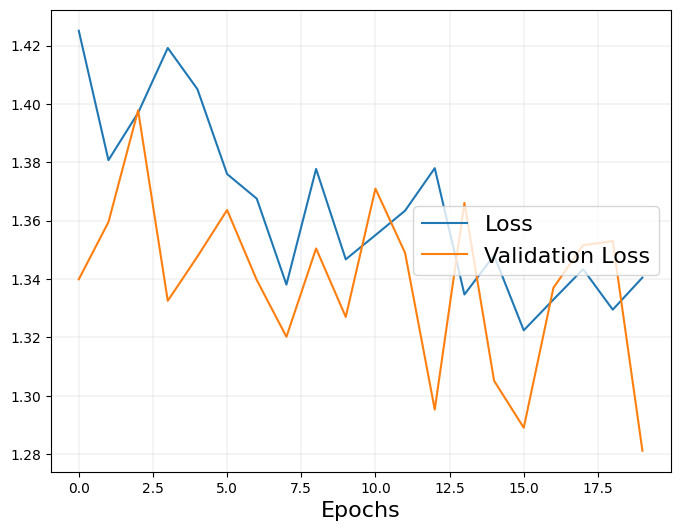

In [15]:
plt.figure(figsize=(8, 6))

font_size = 16

plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")

plt.xlabel("Epochs", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center right")

plt.savefig("evals/history_256px_1000samples_model3.pdf", bbox_inches='tight', pad_inches=0)

plt.show()


In [ ]:
# Resolution

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 1000
evaluations = {}

def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label


for ev_image_size in [50, 100, 150, 200, 250, 300, 350, 400]:
    
    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)

    dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    dataset = dataset.map(normalize_image)
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.repeat()
    
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
        
    model = create_model_2(ev_image_size)
        
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=len(images_train) // BATCH_SIZE, validation_data=val_dataset, validation_steps=len(images_val)//BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weights, verbose=2)
    
    evals = evaluate(model, images_test, labels_test, len(unique_labels))
    
    evaluations[ev_image_size] = evals
    print()
    print(evals)
    print()
    
print(evaluations)

100%|██████████| 200/200 [00:01<00:00, 109.29it/s]


Epoch 1/20
50/50 - 4s - 82ms/step - auc_9: 0.6235 - loss: 1.3988 - val_auc_9: 0.2882 - val_loss: 1.3955
Epoch 2/20
50/50 - 1s - 29ms/step - auc_9: 0.3041 - loss: 1.3865 - val_auc_9: 0.4549 - val_loss: 1.3914
Epoch 3/20
50/50 - 1s - 28ms/step - auc_9: 0.3623 - loss: 1.3866 - val_auc_9: 0.3750 - val_loss: 1.3916
Epoch 4/20
50/50 - 1s - 28ms/step - auc_9: 0.3897 - loss: 1.3874 - val_auc_9: 0.3776 - val_loss: 1.3914
Epoch 5/20
50/50 - 1s - 29ms/step - auc_9: 0.3696 - loss: 1.3866 - val_auc_9: 0.4227 - val_loss: 1.3913
Epoch 6/20
50/50 - 1s - 30ms/step - auc_9: 0.4411 - loss: 1.3876 - val_auc_9: 0.3988 - val_loss: 1.3904
Epoch 7/20
50/50 - 1s - 29ms/step - auc_9: 0.4419 - loss: 1.3892 - val_auc_9: 0.2558 - val_loss: 1.4003
Epoch 8/20
50/50 - 1s - 28ms/step - auc_9: 0.3106 - loss: 1.3876 - val_auc_9: 0.5361 - val_loss: 1.3791
Epoch 9/20
50/50 - 1s - 29ms/step - auc_9: 0.5463 - loss: 1.3979 - val_auc_9: 0.5797 - val_loss: 1.3450
Epoch 10/20
50/50 - 1s - 28ms/step - auc_9: 0.4364 - loss: 1.382

100%|██████████| 200/200 [00:01<00:00, 112.67it/s]


Epoch 1/20
50/50 - 5s - 94ms/step - auc_10: 0.5255 - loss: 1.4701 - val_auc_10: 0.2969 - val_loss: 1.4002
Epoch 2/20
50/50 - 3s - 61ms/step - auc_10: 0.2998 - loss: 1.3880 - val_auc_10: 0.2882 - val_loss: 1.3973
Epoch 3/20
50/50 - 3s - 62ms/step - auc_10: 0.2926 - loss: 1.3872 - val_auc_10: 0.2882 - val_loss: 1.3952
Epoch 4/20
50/50 - 4s - 73ms/step - auc_10: 0.3093 - loss: 1.3868 - val_auc_10: 0.2882 - val_loss: 1.3940
Epoch 5/20
50/50 - 4s - 83ms/step - auc_10: 0.3111 - loss: 1.3868 - val_auc_10: 0.2882 - val_loss: 1.3928
Epoch 6/20
50/50 - 4s - 72ms/step - auc_10: 0.3261 - loss: 1.3866 - val_auc_10: 0.2882 - val_loss: 1.3929
Epoch 7/20
50/50 - 4s - 70ms/step - auc_10: 0.3295 - loss: 1.3868 - val_auc_10: 0.2882 - val_loss: 1.3930
Epoch 8/20
50/50 - 3s - 68ms/step - auc_10: 0.3600 - loss: 1.3868 - val_auc_10: 0.3750 - val_loss: 1.3910
Epoch 9/20
50/50 - 4s - 78ms/step - auc_10: 0.3685 - loss: 1.3864 - val_auc_10: 0.3750 - val_loss: 1.3915
Epoch 10/20
50/50 - 4s - 76ms/step - auc_10: 0

100%|██████████| 200/200 [00:01<00:00, 110.31it/s]


Epoch 1/20
50/50 - 12s - 233ms/step - auc_11: 0.6034 - loss: 2.2589 - val_auc_11: 0.3889 - val_loss: 1.3941
Epoch 2/20
50/50 - 7s - 135ms/step - auc_11: 0.2752 - loss: 1.3869 - val_auc_11: 0.2396 - val_loss: 1.3945
Epoch 3/20
50/50 - 7s - 133ms/step - auc_11: 0.2925 - loss: 1.3869 - val_auc_11: 0.2466 - val_loss: 1.3940
Epoch 4/20
50/50 - 7s - 135ms/step - auc_11: 0.3326 - loss: 1.3937 - val_auc_11: 0.3889 - val_loss: 1.3925
Epoch 5/20
50/50 - 7s - 135ms/step - auc_11: 0.3652 - loss: 1.3862 - val_auc_11: 0.3889 - val_loss: 1.3900
Epoch 6/20
50/50 - 7s - 134ms/step - auc_11: 0.3702 - loss: 1.3873 - val_auc_11: 0.3889 - val_loss: 1.3906
Epoch 7/20
50/50 - 7s - 136ms/step - auc_11: 0.4009 - loss: 1.3869 - val_auc_11: 0.3889 - val_loss: 1.3901
Epoch 8/20
50/50 - 7s - 135ms/step - auc_11: 0.4060 - loss: 1.3861 - val_auc_11: 0.3889 - val_loss: 1.3902
Epoch 9/20
50/50 - 7s - 136ms/step - auc_11: 0.3702 - loss: 1.3864 - val_auc_11: 0.3889 - val_loss: 1.3893
Epoch 10/20
50/50 - 7s - 135ms/step 

100%|██████████| 200/200 [00:01<00:00, 110.26it/s]


Epoch 1/20
50/50 - 15s - 293ms/step - auc_12: 0.4168 - loss: 1.8624 - val_auc_12: 0.2880 - val_loss: 1.4044
Epoch 2/20
50/50 - 13s - 253ms/step - auc_12: 0.2387 - loss: 1.3867 - val_auc_12: 0.2891 - val_loss: 1.4011
Epoch 3/20
50/50 - 13s - 264ms/step - auc_12: 0.2457 - loss: 1.3876 - val_auc_12: 0.2891 - val_loss: 1.3980
Epoch 4/20
50/50 - 13s - 253ms/step - auc_12: 0.3042 - loss: 1.3864 - val_auc_12: 0.2973 - val_loss: 1.3944
Epoch 5/20
50/50 - 12s - 248ms/step - auc_12: 0.3567 - loss: 1.3877 - val_auc_12: 0.3717 - val_loss: 1.3941
Epoch 6/20
50/50 - 12s - 245ms/step - auc_12: 0.4781 - loss: 1.3901 - val_auc_12: 0.2950 - val_loss: 1.4084
Epoch 7/20
50/50 - 13s - 255ms/step - auc_12: 0.3031 - loss: 1.3834 - val_auc_12: 0.6171 - val_loss: 1.3446
Epoch 8/20
50/50 - 12s - 245ms/step - auc_12: 0.5697 - loss: 1.3685 - val_auc_12: 0.3603 - val_loss: 1.4191
Epoch 9/20
50/50 - 12s - 246ms/step - auc_12: 0.5348 - loss: 1.3336 - val_auc_12: 0.3337 - val_loss: 1.4390
Epoch 10/20
50/50 - 12s - 24

100%|██████████| 200/200 [00:01<00:00, 108.10it/s]


Epoch 1/20
50/50 - 22s - 438ms/step - auc_13: 0.5316 - loss: 2.6606 - val_auc_13: 0.2882 - val_loss: 1.3995
Epoch 2/20
50/50 - 19s - 376ms/step - auc_13: 0.2566 - loss: 1.3869 - val_auc_13: 0.2891 - val_loss: 1.3969
Epoch 3/20
50/50 - 20s - 390ms/step - auc_13: 0.2834 - loss: 1.3861 - val_auc_13: 0.2648 - val_loss: 1.3938
Epoch 4/20
50/50 - 21s - 428ms/step - auc_13: 0.3346 - loss: 1.3868 - val_auc_13: 0.4549 - val_loss: 1.3912
Epoch 5/20
50/50 - 19s - 379ms/step - auc_13: 0.3492 - loss: 1.3871 - val_auc_13: 0.5000 - val_loss: 1.3907
Epoch 6/20
50/50 - 20s - 394ms/step - auc_13: 0.3738 - loss: 1.3866 - val_auc_13: 0.3889 - val_loss: 1.3901
Epoch 7/20
50/50 - 20s - 397ms/step - auc_13: 0.3836 - loss: 1.3869 - val_auc_13: 0.4549 - val_loss: 1.3906
Epoch 8/20
50/50 - 21s - 418ms/step - auc_13: 0.4113 - loss: 1.3866 - val_auc_13: 0.4549 - val_loss: 1.3887
Epoch 9/20
50/50 - 19s - 389ms/step - auc_13: 0.4477 - loss: 1.3861 - val_auc_13: 0.5000 - val_loss: 1.3880
Epoch 10/20
50/50 - 19s - 38

100%|██████████| 200/200 [00:01<00:00, 106.07it/s]


Epoch 1/20
50/50 - 33s - 652ms/step - auc_14: 0.4031 - loss: 2.7473 - val_auc_14: 0.2812 - val_loss: 1.4052
Epoch 2/20
50/50 - 28s - 562ms/step - auc_14: 0.3185 - loss: 1.3903 - val_auc_14: 0.2812 - val_loss: 1.4100
Epoch 3/20
50/50 - 29s - 589ms/step - auc_14: 0.2244 - loss: 1.3865 - val_auc_14: 0.2812 - val_loss: 1.4078
Epoch 4/20
50/50 - 29s - 573ms/step - auc_14: 0.2295 - loss: 1.3865 - val_auc_14: 0.2812 - val_loss: 1.4050
Epoch 5/20
50/50 - 28s - 560ms/step - auc_14: 0.2235 - loss: 1.3874 - val_auc_14: 0.2509 - val_loss: 1.4036
Epoch 6/20
50/50 - 30s - 598ms/step - auc_14: 0.3826 - loss: 1.3855 - val_auc_14: 0.4884 - val_loss: 1.3803
Epoch 7/20
50/50 - 30s - 605ms/step - auc_14: 0.6277 - loss: 1.3726 - val_auc_14: 0.5960 - val_loss: 1.3352
Epoch 8/20
50/50 - 28s - 560ms/step - auc_14: 0.6680 - loss: 1.2967 - val_auc_14: 0.6824 - val_loss: 1.4297
Epoch 9/20
50/50 - 27s - 550ms/step - auc_14: 0.7386 - loss: 1.1598 - val_auc_14: 0.6490 - val_loss: 1.5345
Epoch 10/20
50/50 - 28s - 56

100%|██████████| 200/200 [00:02<00:00, 99.70it/s] 


Epoch 1/20
50/50 - 48s - 952ms/step - auc_15: 0.5627 - loss: 3.1404 - val_auc_15: 0.2891 - val_loss: 1.3947
Epoch 2/20
50/50 - 40s - 800ms/step - auc_15: 0.2944 - loss: 1.3866 - val_auc_15: 0.2891 - val_loss: 1.3953
Epoch 3/20
50/50 - 38s - 760ms/step - auc_15: 0.2801 - loss: 1.3864 - val_auc_15: 0.2891 - val_loss: 1.3955
Epoch 4/20
50/50 - 39s - 777ms/step - auc_15: 0.2941 - loss: 1.3869 - val_auc_15: 0.4549 - val_loss: 1.3916
Epoch 5/20
50/50 - 40s - 800ms/step - auc_15: 0.3571 - loss: 1.3877 - val_auc_15: 0.4549 - val_loss: 1.3913
Epoch 6/20
50/50 - 38s - 768ms/step - auc_15: 0.3670 - loss: 1.3870 - val_auc_15: 0.4549 - val_loss: 1.3908
Epoch 7/20
50/50 - 39s - 786ms/step - auc_15: 0.3571 - loss: 1.3865 - val_auc_15: 0.4549 - val_loss: 1.3903
Epoch 8/20
50/50 - 40s - 799ms/step - auc_15: 0.4004 - loss: 1.3867 - val_auc_15: 0.4549 - val_loss: 1.3889
Epoch 9/20
50/50 - 42s - 843ms/step - auc_15: 0.4104 - loss: 1.3864 - val_auc_15: 0.4549 - val_loss: 1.3893
Epoch 10/20
50/50 - 49s - 97

100%|██████████| 200/200 [00:01<00:00, 104.99it/s]


Epoch 1/20
50/50 - 73s - 1s/step - auc_16: 0.4523 - loss: 4.8814 - val_auc_16: 0.2882 - val_loss: 1.3979
Epoch 2/20
50/50 - 68s - 1s/step - auc_16: 0.2821 - loss: 1.3871 - val_auc_16: 0.2882 - val_loss: 1.3971
Epoch 3/20
50/50 - 73s - 1s/step - auc_16: 0.2786 - loss: 1.3873 - val_auc_16: 0.2882 - val_loss: 1.3963
Epoch 4/20


In [ ]:
os.getpid()

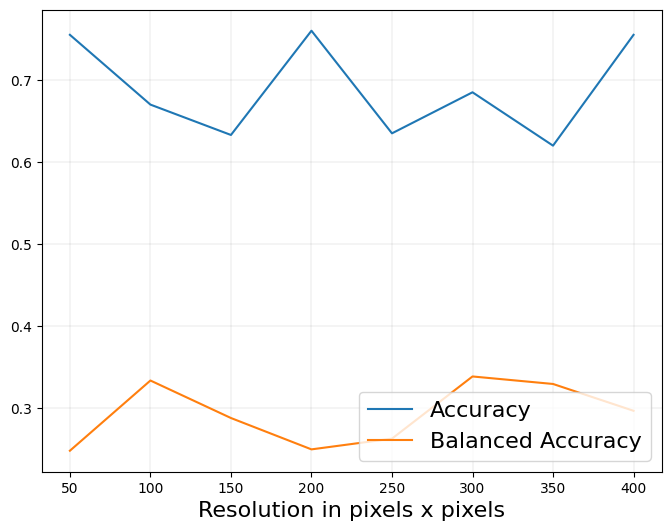

In [14]:
plt.figure(figsize=(8, 6))

with open("pickles/own_models/image_test_fix/resolution_1000samples_model2", "wb") as file:
    pickle.dump(evaluations, file)
    
temp = list(evaluations[150])
temp[2] = 0.633
evaluations[150] = temp

aucs = [evalu[0] for evalu in evaluations.values()]
aucs_at = [evalu["Atelectasis"] for evalu in aucs]
aucs_ef = [evalu["Effusion"] for evalu in aucs]
aucs_in = [evalu["Infiltration"] for evalu in aucs]
aucs_nf = [evalu["No Finding"] for evalu in aucs]
baccs = [evalu[1] for evalu in evaluations.values()]
accs = [evalu[2] for evalu in evaluations.values()]

x_values = [50, 100, 150, 200, 250, 300, 350, 400]

font_size = 16

plt.plot(x_values, accs, label="Accuracy")
plt.plot(x_values, baccs, label="Balanced Accuracy")

# plt.plot(x_values, aucs_at, label="Atelectasis")
# plt.plot(x_values, aucs_ef, label="Effusion")
# plt.plot(x_values, aucs_in, label="Infiltration")
# plt.plot(x_values, aucs_nf, label="No Finding")

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="lower right")

plt.savefig("evals/own_models/image_test_fix/resolution_accBacc_1000samples_model2.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
# Amount of Images

BATCH_SIZE = 32
NUMBER_OF_IMAGES = 87770
NUMBER_OF_IMAGES = 877
IMAGE_SIZE = 224

images_global, labels_global = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)

images_global = np.repeat(images_global[..., np.newaxis], 3, axis=-1).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

evaluations = {}

def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label


for ev_number_of_images in [3000, 13000, 23000, 33000, 43000, 53000, 63000, 73000]:
    
    ev_number_of_images = ev_number_of_images // 100
    
    images, labels = images_global[:ev_number_of_images], labels_global[:ev_number_of_images]
    images_test, labels_test = images_global[-(int(ev_number_of_images / 5)):], labels_global[-(int(ev_number_of_images / 5)):]

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)

    dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    dataset = dataset.map(normalize_image)
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.repeat()
    
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
        
    model = create_resnet_model(IMAGE_SIZE)
        
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(dataset, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=len(images_train) // BATCH_SIZE, validation_data=val_dataset, validation_steps=len(images_val)//BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weights, verbose=2)
    
    evals = evaluate(model, images_test, labels_test, len(unique_labels))
    
    evaluations[ev_image_size] = evals
    print()
    print(evals)
    print()
    
print(evaluations)

In [ ]:
 # Baseline

images, labels = prepare_data(df[:10000], 1)

# Calculate class probabilities
class_counts = np.sum(labels, axis=0)
class_probabilities = class_counts / len(labels)

# Prepare the test data
images_test, labels_test = prepare_data(df[-2000:], 1)

# Generate predictions based on class probabilities
predictions = []
for _ in range(len(labels_test)):
    predicted_class = np.random.choice(len(class_probabilities), p=class_probabilities)
    predictions.append(predicted_class)
    
predictions_proba = np.zeros((len(labels_test), len(class_probabilities)))
for i, predicted_class in enumerate(predictions):
    predictions_proba[i, predicted_class] = 1
    
evals = []
for class_idx in range(4):
    true_labels = labels_test[:, class_idx]  # True labels for this class
    pred_probs = predictions_proba[:, class_idx]  # Predicted probabilities for this class

    # Calculate the AUC for this class
    auc = sklearn.metrics.roc_auc_score(true_labels, pred_probs)
    evals.append(auc)
    print(f"AUC for class {class_idx}: {auc}")
    
    
probabilities_transformed = predictions
labels_val_transformed = labels_test.argmax(axis=1)

balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_val_transformed, probabilities_transformed)
acc = sklearn.metrics.accuracy_score(labels_val_transformed, probabilities_transformed)

print(balanced_acc)
print(acc)

In [ ]:
# tf.keras.utils.plot_model(create_model_2(256), show_shapes=False, rankdir="LR")

birne = create_model_3(256)
def myprint(s):
    with open('test.txt','w') as f:
        print(s, file=f)

birne.summary(print_fn=myprint)

In [ ]:
# Train for balanced accuracy
class_weights = {}
num_classes = len(unique_labels)

for class_idx in range(num_classes):
    class_count = np.sum(labels[:, class_idx])
    class_weight = len(labels) / (num_classes * (class_count + 1e-5)) 
    class_weights[class_idx] = class_weight


model.fit(dataset, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=len(images) // BATCH_SIZE, class_weight=class_weights, validation_data=(images_val, labels_val))
probabilities = model.predict(images_test)
predictions = probabilities.argmax(axis=1)
labels_test = labels_test.argmax(axis=1)

balanced_acc = sklearn.metrics.balanced_accuracy_score(labels_test, predictions)

balanced_acc